This script fits an classifier to a different amounts of training data and plots performance accuracy as a function of sample size. we use this to compare summary text based classification with review text classification. This comparison will apply under specific conditions.

1) we're using LinearSVC as a classifier

2) We use a semantic net model, with 300 d

3) We stem our words, rather than lematize

Our conclusions may not generalize to different classifiers, different language models, or even the same kinds of models with different complexity, nor to summary and review text preprocessed using lematization instead of stemming. Nevertheless, the comparison does provide a proof of principle which can be applied to resolving very specific ambiguitives we may want to investigate.

In [1]:
import time
start_time = time.time()

import json

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np

import sys
sys.path.append("../libraries/")
from selector import split_data
from semanticClassifiers import docTopTransformer

In [225]:
# Read in testing data for 80/20 split
# we won't use val_dat at all
json_dat, val_dat = split_data('../data/Sports_and_Outdoors_Reviews_training.json', 80)
del val_dat

In [226]:
# create lists with one review per elem
summary = []
review = []
rating = []
prod_id = []
for i in range(0,len(json_dat)):
    if json_dat[i].get('reviewText') and json_dat[i].get('summary'): #not all reviews have text
        rating.append(json_dat[i].get('overall'))
        summary.append(json_dat[i].get('summary'))
        review.append(json_dat[i].get('reviewText'))
        prod_id.append(json_dat[i].get('asin'))
        
del json_dat

In [5]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [this_tok for this_tok in tokens if not this_tok in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(this_tok) for this_tok in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [228]:
awesome = np.array(rating) >= 4.5
clean_review_text=preprocess_data(review)
clean_summary_text=preprocess_data(summary)
del review
del rating

In [236]:
from gensim.corpora import Dictionary
import gensim.matutils as matutils

from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import time

# get performance estimates for n_models using k-fold cross validation
k = 5
n_models = np.minimum(len(sample_idx), 10)

old_sample_idx = []
nn = []
sample_idx = []
summary_acc = []
summary_t = []
review_acc = []
review_t = []

review_cv_fold_scores=[]
summary_cv_fold_scores=[]
for rep in range(0,7):
    # generate random nonoverlapping samples of different numbers of elements
    # sample lengths will be log distributed
    # sample_idx will be an array of arrays, with each array containing
    # the indices of a set. Smaller sets will be earlier in the stack, so
    # sample_idx[0] is the smallest and sample_idx[-1] is the largest
    if sample_idx:
        old_sample_idx = np.hstack(np.hstack([old_sample_idx, sample_idx]))

    n = [np.int(x) for x in np.logspace(8, 15, num=10, base=2)]
    cum_n = []
    for x in n:
        cum_n.append(np.int(np.sum(cum_n[-1:]) + x))

    idx = np.random.permutation([x for x in range(0, len(awesome)) if x not in old_sample_idx])

    sample_idx = [idx[range(0,cum_n[0])]]
    
    for i in range(1, len(n)):
        this_sample_idx = idx[range(cum_n[i-1], cum_n[i])]

        for j in range(1,i-1):
            assert all([a not in this_sample_idx for a in sample_idx[j]])
        assert all([a not in this_sample_idx for a in old_sample_idx])

        sample_idx.append(this_sample_idx)

    # fit models for sets selected above
    this_n = []
    this_review_acc = []
    this_review_t = []
    this_summary_acc = []
    this_summary_t = []
    for i in range(0,n_models):
        # these will be the same for both review and summary text
        train_lbls = awesome[sample_idx[i]]
        this_prod_id = [prod_id[i] for i in sample_idx[i]]
        
        # size of a training set during cross validation
        this_n.append(len(train_lbls)*(k-1.0)/k)
        
        #################################
        ### review text specific code ###        
        #################################
        train_text = [clean_review_text[i] for i in sample_idx[i]]
        
        # train a document-topic model        
        this_dict = Dictionary(train_text)

        # transform corpus (train) into a 2d array word counts (a 'bag of words')
        bow_train = [this_dict.doc2bow(text) for text in train_text]
        bow_train = np.transpose(matutils.corpus2dense(bow_train, len(this_dict)))


        # GroupKFold gives you a KFold partitioner that abides by
        # product labels so that products are only ever in a single
        # fold
        gkf = GroupKFold(n_splits=k)
        cv = gkf.split(bow_train, train_lbls, groups=this_prod_id)

        # initialize a transformer mapping from bow to latent semantic features
        bow2Top = docTopTransformer(this_dict=this_dict, d=300, distributed=False)
        # pick a classifier
        clf = LinearSVC()
        # create a pipeline that transforms data to semantic space, 
        # and then classifies them using clf
        estimators = [('projection', bow2Top), ('clf', clf)]
        semClf = Pipeline(estimators)

        try:
            # cross validate over the pipeline using group k-fold CV
            t0 = time.time()
            this_score = cross_val_score(semClf, bow_train, train_lbls, cv=cv)
            t1 = time.time()

            this_review_acc.append(np.mean(this_score))
            this_review_t.append(t1 - t0)
            
            # we'll save an instance of these scores to illustrate
            # some statistical features below
            if rep==0:
                review_cv_fold_scores.append(this_score)
        except:
            print('error on model ' + str(i) + ' of rep ' + str(rep))
            
            this_review_acc.append([])
            this_review_t.append([])
            if rep==0:
                review_cv_fold_scores.append([])
            
        #################################
        ### sumary text specific code ###
        #################################
        train_text = [clean_summary_text[i] for i in sample_idx[i]]

        this_dict = Dictionary(train_text)

        bow_train = [this_dict.doc2bow(text) for text in train_text]
        bow_train = np.transpose(matutils.corpus2dense(bow_train, len(this_dict)))

        gkf = GroupKFold(n_splits=k)
        cv = gkf.split(bow_train, train_lbls, groups=this_prod_id)

        bow2Top = docTopTransformer(this_dict=this_dict, d=300, distributed=False)
        clf = LinearSVC()
        estimators = [('projection', bow2Top), ('clf', clf)]
        semClf = Pipeline(estimators)
        
        try:
            # cross validate over the pipeline using group k-fold CV
            t0 = time.time()
            this_score = cross_val_score(semClf, bow_train, train_lbls, cv=cv)
            t1 = time.time()

            this_summary_acc.append(np.mean(this_score))
            this_summary_t.append(t1 - t0)
            
            # we'll save an instance of these scores to illustrate
            # some statistical features below
            if rep==0:
                summary_cv_fold_scores.append(this_score)
        except:
            print('error on model ' + str(i) + ' of rep ' + str(rep))
            
            this_summary_acc.append([])
            this_summary_t.append([])
            if rep==0:
                summary_cv_fold_scores.append(this_score)
        
    # this assumes at least one model successfully evaluated above. It's a safe assumption
    review_acc.append(this_review_acc)
    summary_acc.append(this_summary_acc)
    nn.append(this_n)
    review_t.append(this_review_t)
    summary_t.append(this_summary_t)

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

error on model 1 of rep 3


/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

error on model 1 of rep 5


/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

error on model 1 of rep 6


/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/sklearn/svm/_base.py:977: C

In [ ]:
# do some cleanup
import copy
review_acc_bak = copy.deepcopy(review_acc)
review_t_bak = copy.deepcopy(review_t)
summary_acc_bak = copy.deepcopy(summary_acc)
summary_t_bak = copy.deepcopy(summary_t)

In [ ]:
# do some cleanup, manually code this to handle errors from above
import copy
#review_acc_bak = copy.deepcopy(review_acc)
#review_t_bak = copy.deepcopy(review_t)
#summary_acc_bak = copy.deepcopy(summary_acc)
#summary_t_bak = copy.deepcopy(summary_t)
review_acc = copy.deepcopy(review_acc_bak)
review_t = copy.deepcopy(review_t_bak)
summary_acc = copy.deepcopy(summary_acc_bak)
summary_t = copy.deepcopy(summary_t_bak)

review_acc[3].insert(1,[])
review_t.insert(2,[])
review_t[3].insert(1,[])

review_acc[5].insert(1,[])
review_t[5].insert(1,[])

review_acc[6].insert(1,[])
review_t[6].insert(1,[])

review_acc = [review[slice(0,20,2)] for review in review_acc]
review_t = [review[slice(0,20,2)] for review in review_t]
summary_acc = [summary[slice(0,20,2)] for summary in summary_acc]
summary_t = [summary[slice(0,20,2)] for summary in summary_t]

/home/bogdan/miniconda3/envs/mlclass/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = N.array(data, dtype=dtype, copy=copy)


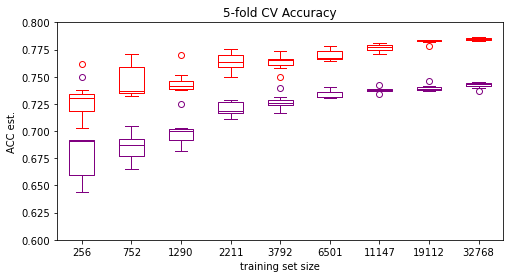

In [472]:
plt.figure(figsize=(8,4))
m_acc = np.matrix(summary_acc)
m_acc = m_acc[:,(0,2,3,4,5,6,7,8,9)]
'''
mu_acc = np.array(np.mean(m_acc, axis=0))
s_acc = np.array(np.std(m_acc, ddof=1, axis=0)/np.sqrt(7))

x = np.transpose(np.array([x for x in range(1,11)]))
plt.bar(x,mu_acc[0],yerr=s_acc[0]);
'''
c1 = "red"
box1 = plt.boxplot(m_acc)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c1)
plt.setp(box1["fliers"], markeredgecolor=c1)


m_acc = np.matrix(review_acc)
m_acc = m_acc[:,(0,2,3,4,5,6,7,8,9)]

c2 = "purple"
box2 = plt.boxplot(m_acc)

for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box2[item], color=c2)
plt.setp(box2["fliers"], markeredgecolor=c2)

plt.xticks(range(1,10),labels=[n[i] for i in [0,2,3,4,5,6,7,8,9]])

plt.xlabel('training set size');
plt.ylabel('ACC est.');
plt.ylim([0.6,0.8]);
plt.title('5-fold CV Accuracy');